In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sn

C:\Users\co1012351486\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Loading

In [2]:
data = pd.read_csv("orders.csv", sep=",")

### Data Understanding

In [3]:
data.head()

,order_id,store_id,to_user_distance,to_user_elevation,total_earning,created_at,taken
0,14364873,30000009,2.478101,-72.719360,4200,2017-09-07T20:02:17Z,0
1,14370123,30000058,0.451711,37.754761,4200,2017-09-07T20:13:16Z,0
2,14368534,900003684,2.026072,207.191162,4000,2017-09-07T20:07:23Z,0
3,14370258,900014452,2.671432,1.722656,4400,2017-09-07T20:15:19Z,1
4,14369923,900014085,0.965496,117.429199,3450,2017-09-07T20:12:14Z,1


In [4]:
data.dtypes

order_id               int64
store_id               int64
to_user_distance     float64
to_user_elevation    float64
total_earning          int64
created_at            object
taken                  int64
dtype: object

### Data transformation

In [5]:
data.order_id = data.order_id.astype(str)
data.store_id = data.store_id.astype(str)
data.created_at = pd.to_datetime(data.created_at)

data['month'] = data.created_at.dt.month
data.month = data.month.astype(str)
## The day of the week with Monday=0, Sunday=6.
data['day_of_week'] = data.created_at.dt.dayofweek
data.day_of_week = data.day_of_week.astype(str)
data['day_of_month'] = data.created_at.dt.day
data.day_of_month = data.day_of_month.astype(str)

In [6]:
data.dtypes

order_id                     object
store_id                     object
to_user_distance            float64
to_user_elevation           float64
total_earning                 int64
created_at           datetime64[ns]
taken                         int64
month                        object
day_of_week                  object
day_of_month                 object
dtype: object

### Data selection

In [7]:
data = data.drop(['order_id'], axis=1)
data = data.drop(['created_at'], axis=1)
# Pendiente validar si todas las ordenes son únicas
data.head()

,store_id,to_user_distance,to_user_elevation,total_earning,taken,month,day_of_week,day_of_month
0,30000009,2.478101,-72.719360,4200,0,9,3,7
1,30000058,0.451711,37.754761,4200,0,9,3,7
2,900003684,2.026072,207.191162,4000,0,9,3,7
3,900014452,2.671432,1.722656,4400,1,9,3,7
4,900014085,0.965496,117.429199,3450,1,9,3,7


In [8]:
pandas_profiling.ProfileReport(data)

Number of variables,8
Number of observations,146987
Total Missing (%),0.0%
Total size in memory,9.0 MiB
Average record size in memory,64.0 B
Numeric,4
Categorical,4
Date,0
Text (Unique),0
Rejected,0
Distinct count,30


In [9]:
data.shape

(146987, 8)

#### How many orders were not taken by any courier?

According to the profiling the number of ordes was 11580

#### What weekday has the higher percentage of non-taken orders?
R/Is the saturday with 22%

In [10]:
day_of_week_non_taken = data[['day_of_week','taken']]
day_of_week_non_taken = day_of_week_non_taken[day_of_week_non_taken.taken == 0]

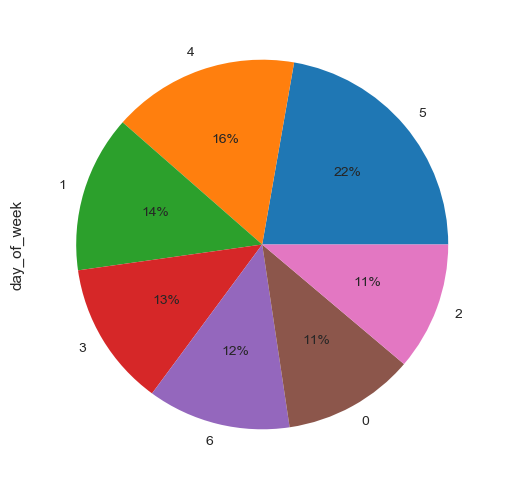

In [11]:
day_of_week_non_taken.day_of_week.value_counts().plot(kind='pie',figsize=(6,6),autopct='%1.0f%%')

### Data cleansing

In [12]:
data = data[np.abs(data.to_user_distance - data.to_user_distance.mean()) <= ( 3 * data.to_user_distance.std())]
data = data[~(np.abs(data.to_user_distance - data.to_user_distance.mean()) > (3 * data.to_user_distance.std()))]

Una vez realizada la limpieza se observa que el conjunto de datos sigue siendo representativo con el 99.4% de los registros. Adicinalmente no se afecta de ninguna manera la variable 'taken', en relación a los valores 0 ya que sigue siendo 11508.

In [13]:
data.shape

(146163, 8)

In [14]:
146163/146987

0.9943940620599101

In [15]:
pandas_profiling.ProfileReport(data)

Number of variables,9
Number of observations,146163
Total Missing (%),0.0%
Total size in memory,10.0 MiB
Average record size in memory,72.0 B
Numeric,5
Categorical,4
Date,0
Text (Unique),0
Rejected,0
Distinct count,30


### Modeling

In [16]:
X = data.loc[:, data.columns != 'taken']

In [17]:
y = data.taken

#### Decision Tree

In [18]:
from sklearn import tree
import graphviz
from sklearn.tree import export_graphviz

0.8600808686192812


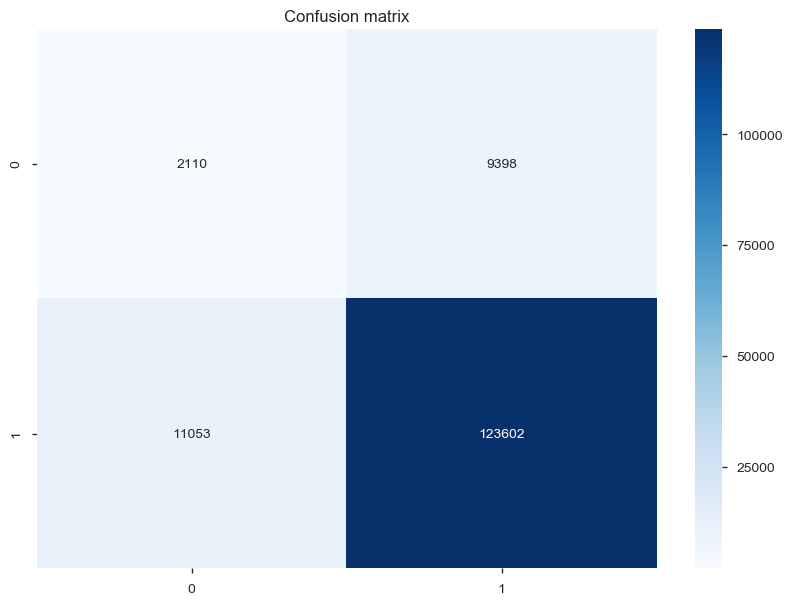

In [19]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X, y)
y_pred = cross_val_predict(decision_tree, X, y, cv=10)
print(accuracy_score(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sn.heatmap(conf_mat,annot=True,cmap='Blues', fmt='g')

In [20]:
print("Accuracy: ", round(accuracy_score(y,y_pred),3))
print("Recall: ", round(recall_score(y,y_pred,average='macro'),3))
print("Precision: ", round(precision_score(y,y_pred,average='macro'),3))
print("F1-score: ", round(f1_score(y,y_pred,average='macro'),3))

Accuracy:  0.86
Recall:  0.551
Precision:  0.545
F1-score:  0.547


#### Naive Bayes

Data Binarization

In [21]:
data_numeric = X.select_dtypes(include = ['number'])
data_categorical = X.select_dtypes(include = ['object'])
data_binary = pd.get_dummies(data_categorical)
X = pd.merge(data_numeric,data_binary,how = 'inner', on = data_numeric.index)

Data normalization

In [22]:
from sklearn import preprocessing

## Nomalization between -1 and 1
x = X[['to_user_elevation']].values
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
X.to_user_elevation = df


## Nomalization between 0 and 1
x = X[['to_user_distance']].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
X.to_user_distance = df


x = X[['total_earning']].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
X.total_earning = df
X.head()

C:\Users\co1012351486\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,key_0,to_user_distance,to_user_elevation,total_earning,store_id_30000003,store_id_30000007,store_id_30000009,store_id_30000016,store_id_30000017,store_id_30000018,...,day_of_month_28,day_of_month_29,day_of_month_3,day_of_month_30,day_of_month_4,day_of_month_5,day_of_month_6,day_of_month_7,day_of_month_8,day_of_month_9
0,0,0.625004,-0.117117,0.038817,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0.113926,0.068461,0.038817,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,0.510997,0.353086,0.036969,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3,0.673764,0.007933,0.040665,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,4,0.243509,0.202301,0.031885,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


0.9212659838673262


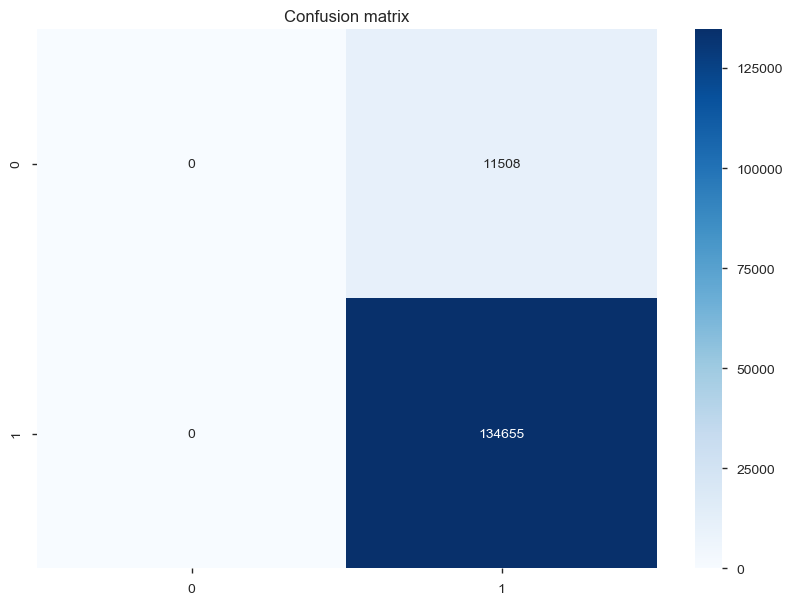

In [23]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = cross_val_predict(gnb, X, y, cv=10)
print(accuracy_score(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sn.heatmap(conf_mat,annot=True,cmap='Blues', fmt='g')

In [24]:
print("Accuracy: ", round(accuracy_score(y,y_pred),3))
print("Recall: ", round(recall_score(y,y_pred,average='macro'),3))
print("Precision: ", round(precision_score(y,y_pred,average='macro'),3))
print("F1-score: ", round(f1_score(y,y_pred,average='macro'),3))

Accuracy:  0.921
Recall:  0.5
Precision:  0.461
F1-score:  0.48


C:\Users\co1012351486\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\co1012351486\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Neural Network Model

0.9212659838673262


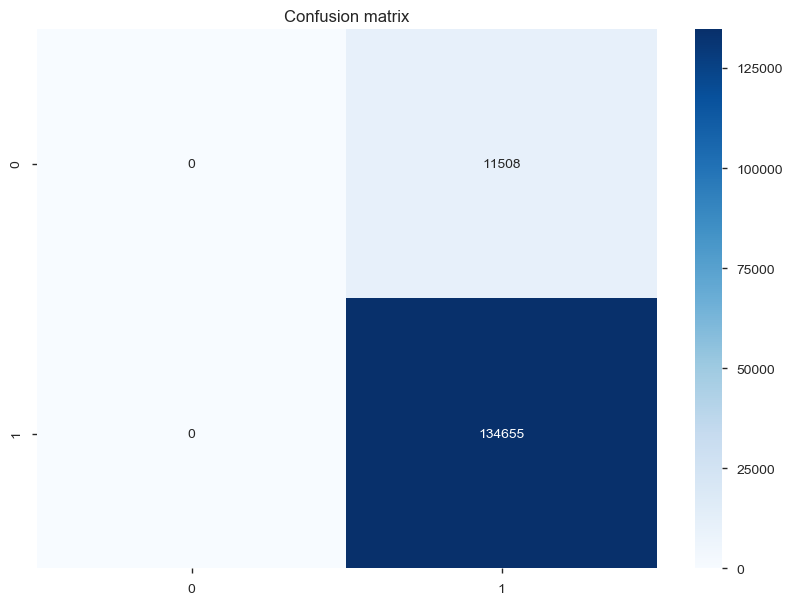

In [25]:
nn = MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(5, 5, 5), random_state=1)
y_pred = cross_val_predict(nn, X, y, cv=10)
print(accuracy_score(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sn.heatmap(conf_mat,annot=True,cmap='Blues', fmt='g')

In [26]:
print("Accuracy: ", round(accuracy_score(y,y_pred),3))
print("Recall: ", round(recall_score(y,y_pred,average='macro'),3))
print("Precision: ", round(precision_score(y,y_pred,average='macro'),3))
print("F1-score: ", round(f1_score(y,y_pred,average='macro'),3))

Accuracy:  0.921
Recall:  0.5
Precision:  0.461
F1-score:  0.48


C:\Users\co1012351486\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\co1012351486\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### About the challenge

The challenge correspond to a classification problem. There are several algorithms to solve this problem, between are: decision trees, SVM, logistic regression and neural networks.

#### Discuss why you chose your approach

For this case I choose the algorithms decision trees, naive bayes and neural networks based on the type of problem and data characteristics.

#### What alternatives you considered?

For this case only decision trees, naive bayes and neural networks but could be possible also with another algorithms for examplea logistic regression.

#### How valid is your model? 

All the models were validated by cross validation. The key indicators of model performance are shown after of the traning and validation of each model.

#### Briefly discuss how Rappi can take advantage of the insights gained from the model to increase the number orders taken by our couriers.

Based on the prediction of models could implement incentives for the courier for make more attractive the orders and reduce the numbers of cancelled orders.

### Conclusion

For the experimentation in a general view the best model was the decision tree, but some models like the neural network could be optimized finding the best configuration for the neurons.